In [1]:
import numpy as np
import sympy as sy
from matplotlib import pyplot as plt
from IPython.display import display
import pickle
from itertools import product
import sys

# n species

In [2]:
save_res = True
num_samples = 1e2 #per q value
# kappa, lamda = sy.symbols("kappa lamda")
n_arr = np.arange(3, 12*4, 12) # Number of species
q_arr = np.linspace(0, 1, 5) # Probability of dispersal off diagonal
c = 1.0 # Connectance (probability of interaction off diagonal
mean_Jij = 0.2 # Expected value of interaction off diagonals
kappas = np.arange(0, 1e2, 5)

In [3]:
for q in q_arr:
    all_data = {'n': n_arr, 
                'phase_fraction': {'ddi': [], 
                                   'stab': []}}
    for n in all_data['n']:
        print(n)
        data = {'omega_integrand': {'stab': [], 'ddi': []}}
        while len(data['omega_integrand']['stab']) < num_samples:
            # Construct J and C matricies
            'This J construction seems to always be stable'
            J = np.random.normal(0, mean_Jij, (n,n)) * np.random.binomial(1, c, size=(n,n))
            for i in range(n):
                J[i,i] = -1.
            evs = np.linalg.eig(J)[0]
            # Check for non-spatial stability
            if not np.all(np.real(evs) < 0):
                continue
            C = np.zeros((n,n))
            for i, j in product(range(n), repeat=2):
                if i == j:
                    C[i,j] = 1.0
                elif np.random.binomial(1, q):
                    C[i,j] = np.random.uniform() * -np.sign(J[i,j])
            # M = sy.Matrix(J - kappa*C)
            data['omega_integrand']['stab'].append(True)
            data['omega_integrand']['ddi'].append(False)
            for k in kappas:
                # evs = list(M.subs(kappa, k).eigenvals().keys())
                # re_evs = np.array([float(sy.re(ev)) for ev in evs])
                M = J - k*C
                re_evs = np.linalg.eigvals(M).real
                if np.any(re_evs > 0):
                    data['omega_integrand']['stab'][-1] = False
                    data['omega_integrand']['ddi'][-1] = True

        for phase in ['stab', 'ddi']:
            phase_fraction = sum(data['omega_integrand'][phase]) / num_samples
            all_data['phase_fraction'][phase].append(phase_fraction)

    # Save data to pkl
    if save_res:
        with open('random_matrix_q{}_c{}.pkl'.format(q,c), 'wb') as f:
            pickle.dump(all_data, f)

3
15
27
39
3
15
27
39
3
15
27
39
3
15
27
39
3
15
27
39


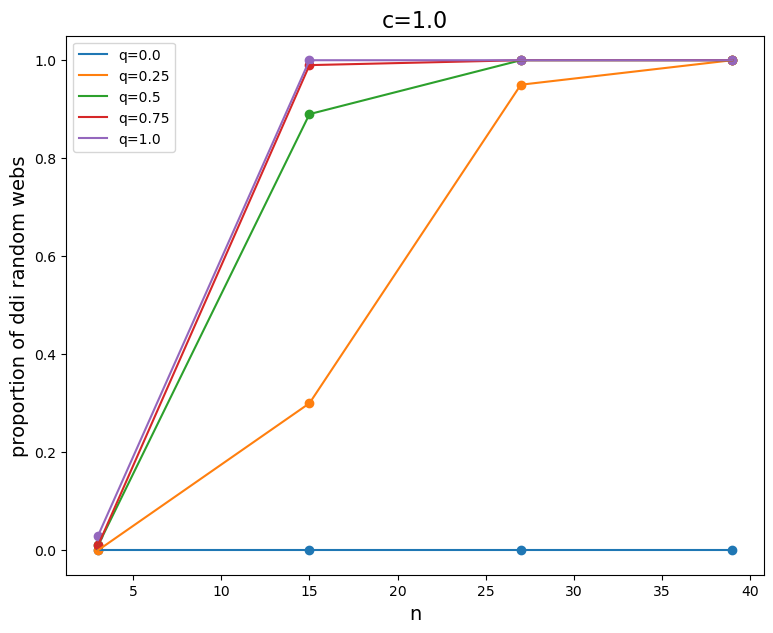

In [8]:
savefig = True
figpath = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
figfn = 'random_matrix_c{}.png'.format(c)
plt.figure(figsize=(9,7))
ax = plt.subplot()
for q in q_arr:
    with open('random_matrix_q{}_c{}.pkl'.format(q,c), 'rb') as file:
        all_data = pickle.load(file)
    # phases = ['stab', 'ddi']
    # colors = ['lightgreen', 'cornflowerblue']
    # labels = ['always stable', 'ddi']
    # for i, phase in enumerate(phases):
    #     ax.scatter(all_data['n'], all_data['phase_fraction'][phase], 
    #                c=colors[i])
    #     ax.plot(all_data['n'], all_data['phase_fraction'][phase], 
    #                c=colors[i], label=labels[i])
    ax.scatter(all_data['n'], all_data['phase_fraction']['ddi'])
    ax.plot(all_data['n'], all_data['phase_fraction']['ddi'], label='q={}'.format(q))
ax.set_xlabel('n', fontsize=14)
ax.set_ylabel('proportion of ddi random webs', fontsize=14)
ax.legend()
ax.set_title('c={}'.format(c), fontsize=16)
if savefig:
    plt.savefig(figpath + figfn, bbox_inches='tight')

# 3 species

In [2]:
save_res = True
num_samples = 5e3 #per q value
q_arr = np.linspace(0,1,5)
# c = 1.0 # Connectance
mean_Jij = 0.2
kappas = np.arange(1e3)
modes = ['constrained', 'unconstrained']
# In order of chain, exploitative, apparent, omnivory
connection_mats = np.array([
                            [[1,1,0],[1,1,1],[0,1,1]],
                            [[1,1,1],[1,1,0],[1,0,1]],
                            [[1,0,1],[0,1,1],[1,1,1]],
                            [[1,1,1],[1,1,1],[1,1,1]]
                            ])

In [17]:
for mode in modes:
    all_data = {'q': q_arr, 
                'phase_fraction': {'stab': [], 
                                   'ddi': []}}
    for q in all_data['q']:
        data = {'kappa_cs': {'wav': [], 'st': []},
                'omega_integrand': {'wav': [], 'st': [], 
                                    'stab': [], 'ddi': []}}
        while len(data['omega_integrand']['stab']) < num_samples:
            # Construct metacommunity jacobian and check for non-spatial stability
            '''Normally distributed offdiagonal, -1 diagonals, specified connectivity'''
            # J = np.random.normal(0, mean_Jij, (3,3)) * np.random.binomial(1, c, size=(3,3))
            # for i in range(3):
            #     J[i,i] = -1.
            ''''''
            '''Normally distributed offdiagonals, diagonals (-1, -0.1), 
               randomly selected module, pred-prey sign constraints'''
            module_i = np.random.choice(len(connection_mats))
            connections = connection_mats[module_i]
            J = np.random.normal(0, mean_Jij, (3,3)) * connections
            np.fill_diagonal(J, np.random.uniform(-1,-0.1,3))
            # Constrain interaction signs for predators/prey
            for i, j in [(0,1), (0,2), (1,2)]:
                if J[i,j] > 0:
                    J[i,j] = -1 * J[i,j]
                if J[j,i] < 0:
                    J[j,i] = -1 * J[j,i]
            ''''''
            evs = np.linalg.eig(J)[0]
            if not np.all(np.real(evs) < 0):
                continue

            # Construct connectivity matrix
            C = np.zeros((3,3))
            for i, j in product(range(C.shape[0]), repeat=2):
                if i == j:
                    # C[i,j] = 1.0
                    C[i,j] = np.random.uniform()
                # With probability q, assign nonzero offdiagonal
                elif np.random.binomial(1, q):
                    if mode == 'constrained':
                        # C[i,j] = np.random.uniform() * -np.sign(J[i,j])
                        # Handle special cases first
                        # Negative interaction between predators in exploitative
                        if (module_i == 1) and ((i,j) in [(1,2), (2,1)]):
                            C[i,j] = np.random.uniform()
                        # Negative interaction between prey in apparent
                        elif (module_i == 2) and ((i,j) in [(0,1), (1,0)]):
                            C[i,j] = np.random.uniform()
                        # Otherwise, opposite sign of interaction
                        else:
                            C[i,j] = np.random.uniform() * -np.sign(J[i,j])
                    elif mode == 'unconstrained':
                        C[i,j] = np.random.uniform(-1,1)
                    else:
                        sys.exit()

            # Check for ddi
            M_vec = np.array([J - k*C for k in kappas])
            re_evs = np.linalg.eigvals(M_vec).real
            any_positive = np.any(re_evs > 0, axis=1)
            ddi = np.any(any_positive)
            data['omega_integrand']['stab'].append(ddi == False)
            data['omega_integrand']['ddi'].append(ddi)

        # Store omega data
        for phase in ['stab', 'ddi']:
            phase_fraction = sum(data['omega_integrand'][phase]) / num_samples
            all_data['phase_fraction'][phase].append(phase_fraction)
        
    # Save data to pkl
    datafn = 'random_matrix_n3_{}_reconstrained.pkl'.format(mode)
    if save_res:
        with open(datafn, 'wb') as f:
            pickle.dump(all_data, f)

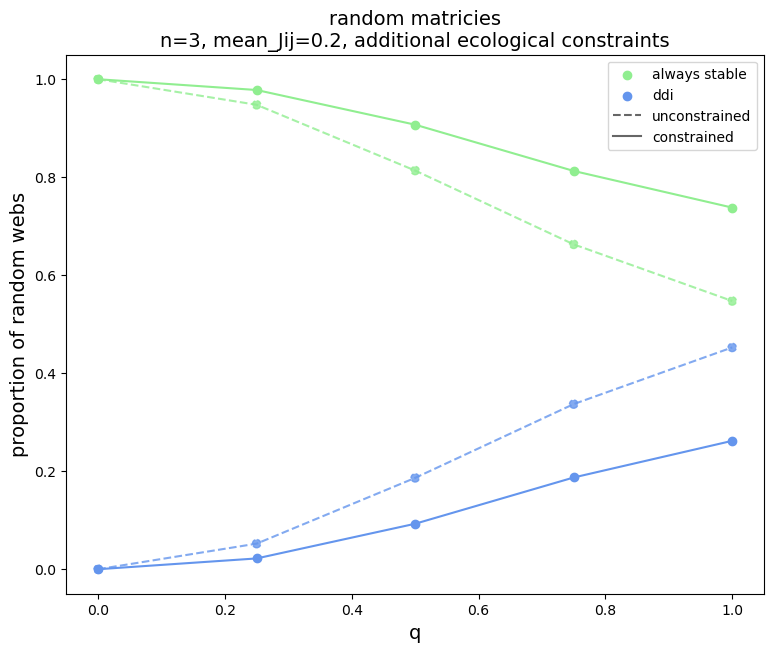

In [18]:
savefig = True
plt.figure(figsize=(9,7))
ax = plt.subplot()
figpath = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
figfn = 'random_matrix_n3_reconstrained_withindiectCij.png'
phases = ['stab', 'ddi']
colors = ['lightgreen', 'cornflowerblue']
labels = ['always stable', 'ddi']
for mode in modes:
    datafn = 'random_matrix_n3_{}_reconstrained.pkl'.format(mode)
    with open(datafn, 'rb') as file:
        all_data = pickle.load(file)
    ls = '-' if mode == 'constrained' else '--'
    alp = 1.0 if mode == 'constrained' else 0.8
    for i, phase in enumerate(phases):
        ax.scatter(all_data['q'], all_data['phase_fraction'][phase], 
                   c=colors[i], ls=ls, alpha=alp)
        ax.plot(all_data['q'], all_data['phase_fraction'][phase], 
                   c=colors[i], ls=ls, alpha=alp)
ax.scatter([], [], c=colors[0], label=labels[0])
ax.scatter([], [], c=colors[1], label=labels[1])
ax.plot([], [], ls='--', alpha=0.6, color='black', label='unconstrained')
ax.plot([], [], alpha=0.6, color='black', label='constrained')
ax.set_xlabel('q', fontsize=14)
ax.set_ylabel('proportion of random webs', fontsize=14)
ax.legend()
ax.set_title('random matricies\nn=3, mean_Jij={}, additional ecological constraints'.format(mean_Jij), fontsize=14)
if savefig:
    plt.savefig(figpath + figfn, bbox_inches='tight')